##### Preparing the Datasets

In [33]:
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split

wine = load_wine()
wine_X_train, wine_X_test, wine_y_train, wine_y_test = train_test_split(wine.data, wine.target, random_state=2402)

In [34]:
import numpy as np

zip_test_X = np.genfromtxt('zip.test', delimiter=' ', usecols=np.arange(1, 257))
zip_test_Y = np.genfromtxt('zip.test', delimiter=' ', usecols=0, dtype='int')
zip_train_X = np.genfromtxt('zip.train', delimiter=' ', usecols=np.arange(1, 257))
zip_train_Y = np.genfromtxt('zip.train', delimiter = ' ', usecols=0).astype(int)

zip_X = np.concatenate([zip_test_X, zip_train_X])
zip_Y = np.concatenate([zip_test_Y, zip_train_Y])
zip_X_train , zip_X_test, zip_y_train, zip_y_test = train_test_split(zip_X, zip_Y, random_state=309)


In [35]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

svm = SVC().fit(wine_X_train, wine_y_train)
generalization_accuracy = cross_val_score(svm, wine_X_train, wine_y_train).mean()
print("Generalization Accuracy for the Wine Dataset: ", generalization_accuracy)

Generalization Accuracy for the Wine Dataset:  0.6917378917378917


In [36]:
test_error_rate = 1 - svm.score(wine_X_test, wine_y_test)
print("Test Error Rate for Wine Dataset: ", test_error_rate)

Test Error Rate for Wine Dataset:  0.4


In [37]:
svm = SVC().fit(zip_X_train, zip_y_train)
generalization_accuracy = cross_val_score(svm, zip_X_train, zip_y_train).mean()
print("Generalization Accuracy for the Zip Dataset: ", generalization_accuracy)


Generalization Accuracy for the Zip Dataset:  0.9710318158210045


In [38]:
test_error_rate = 1 - svm.score(zip_X_test, zip_y_test)
print("Test Error Rate for Zip Dataset: ", test_error_rate)

Test Error Rate for Zip Dataset:  0.03354838709677421


4. The test error rate for the Zip dataset is basically the complement of the Generalization Accuracy for the Zip dataset. For the wine dataset, the Test Error Rate is 0.03 or 3% off from being the complement for the Generalization Accuracy. (NEEDS WORK)

In [39]:
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.pipeline import make_pipeline

scalers = [Normalizer(), StandardScaler(), MinMaxScaler(), RobustScaler()]
pipes = [make_pipeline(scaler, SVC()) for scaler in scalers]
wine_grids = []
zip_grids = []
param_grid = {'svc__C': [0.01, 0.1, 1, 10, 100],
              'svc__gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

from sklearn.model_selection import GridSearchCV

for pipe in pipes:
    grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
    wine_grids.append(grid)
    grid.fit(wine_X_train, wine_y_train)
    print("--------------- Results for " + str(pipe.steps[0][1]) + " ---------------")
    print("Best cross-validation accuracy:", grid.best_score_)
    print("Test set score:", grid.score(wine_X_test, wine_y_test))
    print("Test error rate:", 1 - grid.score(wine_X_test, wine_y_test))
    print("Best Parameters:", grid.best_params_)

--------------- Results for Normalizer() ---------------
Best cross-validation accuracy: 0.9475783475783475
Test set score: 0.9333333333333333
Test error rate: 0.06666666666666665
Best Parameters: {'svc__C': 100, 'svc__gamma': 100}
--------------- Results for StandardScaler() ---------------
Best cross-validation accuracy: 0.9925925925925926
Test set score: 0.9555555555555556
Test error rate: 0.0444444444444444
Best Parameters: {'svc__C': 1, 'svc__gamma': 0.1}
--------------- Results for MinMaxScaler() ---------------
Best cross-validation accuracy: 0.9925925925925926
Test set score: 0.9777777777777777
Test error rate: 0.022222222222222254
Best Parameters: {'svc__C': 0.1, 'svc__gamma': 1}
--------------- Results for RobustScaler() ---------------
Best cross-validation accuracy: 0.9925925925925926
Test set score: 0.9555555555555556
Test error rate: 0.0444444444444444
Best Parameters: {'svc__C': 0.1, 'svc__gamma': 0.1}


In [40]:
for pipe in pipes:
    grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1)
    zip_grids.append(grid)
    grid.fit(zip_X_train, zip_y_train)
    print("--------------- Results for " + str(pipe.steps[0][1]) + " ---------------")
    print("Best cross-validation accuracy:", grid.best_score_)
    print("Test set score:", grid.score(zip_X_test, zip_y_test))
    print("Test error rate:", 1 - grid.score(zip_X_test, zip_y_test))
    print("Best Parameters:", grid.best_params_)

--------------- Results for Normalizer() ---------------
Best cross-validation accuracy: 0.9731830733867112
Test set score: 0.9724731182795698
Test error rate: 0.027526881720430163
Best Parameters: {'svc__C': 100, 'svc__gamma': 1}
--------------- Results for StandardScaler() ---------------
Best cross-validation accuracy: 0.9664426651856651
Test set score: 0.9625806451612903
Test error rate: 0.03741935483870973
Best Parameters: {'svc__C': 10, 'svc__gamma': 0.001}
--------------- Results for MinMaxScaler() ---------------
Best cross-validation accuracy: 0.9690239274309252
Test set score: 0.9673118279569892
Test error rate: 0.03268817204301078
Best Parameters: {'svc__C': 10, 'svc__gamma': 0.01}
--------------- Results for RobustScaler() ---------------
Best cross-validation accuracy: 0.9209759182980823
Test set score: 0.9359139784946237
Test error rate: 0.06408602150537634
Best Parameters: {'svc__C': 100, 'svc__gamma': 0.001}


In [45]:
from sklearn.model_selection import KFold

class cross_conformal_predictor:
    def __init__(self, X_train, y_train, grid):
        self.grid = grid
        self.X_train = X_train
        self.y_train = y_train
    def cross_conformal_predictor(self, X_samples, y_samples, k_folds:int = 5):
        X_train = self.X_train
        y_train = self.y_train
        n_train = len(X_train)
        labels = set(y_train)
        n_test = len(X_samples)
        p = np.zeros((n_test, len(labels)))
        
        kf = KFold(n_splits=k_folds, shuffle = True, random_state=2402)
        
        for rest_index, fold_index in kf.split(X_train, y_train):
            X_rest, X_fold = X_train[rest_index], X_train[fold_index]
            y_rest, y_fold = y_train[rest_index], y_train[fold_index]
            
            self.grid.fit(X_rest, y_rest)
            fold_scores = self.grid.decision_function(X_fold)
            sample_scores = self.grid.decision_function(X_samples)
            true_fold_scores = [(true_class, fold_scores[i][true_class]) for i, true_class in enumerate(y_fold)]
            print(true_fold_scores)
            for i in range(n_test): #check each test sample
                for scores in true_fold_scores: #iterate through fold scores
                    for j in range(len(labels)):
                        if scores[1] <= sample_scores[i][j]:
                            p[i][j] += 1
        print(p)
        for i in range(n_test):
            p[i] = (p[i] + 1)/(n_train + 1)       
        print(p)
        return p
    

In [46]:
ccp = cross_conformal_predictor(wine_X_train, wine_y_train, wine_grids[0])
p_values = ccp.cross_conformal_predictor(wine_X_test, wine_y_test)

[(np.int64(0), np.float64(2.2846966245824474)), (np.int64(1), np.float64(2.2745096054499863)), (np.int64(1), np.float64(2.272648346636991)), (np.int64(2), np.float64(2.275774149776278)), (np.int64(1), np.float64(2.2561747781227495)), (np.int64(1), np.float64(1.211840448292521)), (np.int64(1), np.float64(2.209438540167493)), (np.int64(0), np.float64(2.2853204039316957)), (np.int64(2), np.float64(2.2716176873487948)), (np.int64(2), np.float64(2.1881897231323206)), (np.int64(0), np.float64(2.263292928637926)), (np.int64(2), np.float64(2.255979345684811)), (np.int64(2), np.float64(2.266091445642108)), (np.int64(1), np.float64(2.264720970602114)), (np.int64(2), np.float64(2.2695454195332236)), (np.int64(2), np.float64(2.2162052966433543)), (np.int64(0), np.float64(2.281480076231089)), (np.int64(0), np.float64(0.8098361257798852)), (np.int64(1), np.float64(2.2758645971018634)), (np.int64(2), np.float64(2.1914374246247696)), (np.int64(1), np.float64(2.2571617422307653)), (np.int64(0), np.floa

In [56]:
import math
p_total = 0
for i, label in enumerate(wine_y_test):
    smallest_p_value = -math.inf
    for prediction, confidence in enumerate(p_values[i]):
        if prediction != label:
            p_total += confidence
print(p_total/(len(wine_X_test)))

0.02819237147595356


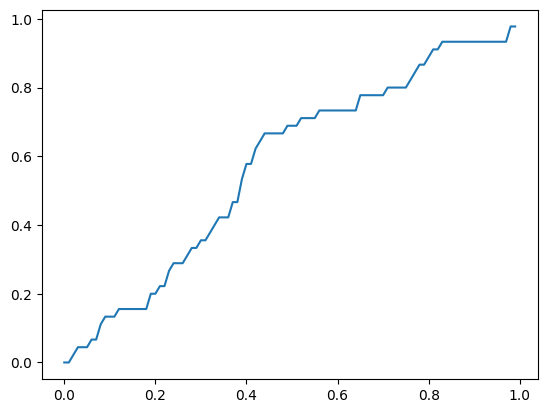

In [57]:
%matplotlib inline
import matplotlib.pyplot as plt

eps = np.zeros(100)
err = np.zeros(100)
for k in range(100):
    eps[k] = k/100
    err[k] = 0
    for j in range(wine_X_test.shape[0]):
        if (p_values[j, wine_y_test[j]] <= eps[k]):
            err[k] = err[k] + 1
    err[k] = err[k] / wine_X_test.shape[0]
plt.plot(eps, err)